
# Export DeePTB to Wannier90 files

This notebook verifies the correctness of DeePTB's Wannier90 (`_hr.dat`) export by:
1.  **Exporting** a DeePTB model to `_hr.dat`.
2.  **Loading** the exported file back using `PythTB`'s `w90` interface.
3.  **Calculating** bands with both methods and comparing them visually.


In [1]:

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from dptb.nn import build_model
from dptb.postprocess.interfaces import ToWannier90
from dptb.postprocess.bandstructure.band import Band
from pythtb import w90
from ase.io import read


TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.


In [ ]:

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from dptb.nn import build_model
from dptb.postprocess.interfaces import ToWannier90
from dptb.postprocess.bandstructure.band import Band
from pythtb import w90
from ase.io import read


TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.


In [3]:
# Define paths
root_dir = os.path.abspath(".") 
model_path = os.path.join(root_dir, "models", "nnsk.ep20.pth")
struct_path = os.path.join(root_dir, "silicon.vasp")
export_dir = os.path.join(root_dir, "w90_output")

# Clean/Create output dir
if os.path.exists(export_dir):
    shutil.rmtree(export_dir)
os.makedirs(export_dir, exist_ok=True)

# Load Model
print(f"Loading model from {model_path}...")
model = build_model(model_path)
model.eval()
print("Model loaded.")


The model option atomic_radius in nnsk is not defined in input model_options, set to v1.


Loading model from /Users/aisiqg/Desktop/work/github/DeePTB/examples/ToW90_PythTB/models/nnsk.ep20.pth...
Model loaded.



## 1. DeePTB Native Band Structure (Reference)


/Users/aisiqg/Desktop/work/github/DeePTB/.venv/lib/python3.10/site-packages/torch/nested/__init__.py:107: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  return torch._nested_tensor_from_tensor_list(ts, dtype, None, device, None)
eig_solver is not set, using default 'torch'.


DeePTB Bands Calculated. Shape: (351, 18)


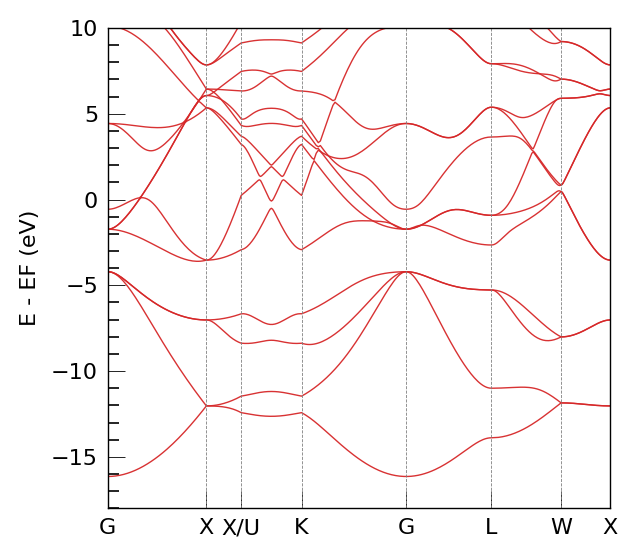

In [5]:

# Configuration for Band Calculation
jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   50],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "nel_atom":{"Si":4},
        "E_fermi":-4.722,
        "emin":-18,
        "emax":10,
        "ref_band": None 
    }
}
kpath_kwargs = jdata["task_options"]

# Calculate Bands
bcal = Band(model=model, use_gui=False, device=model.device)
band_data = bcal.get_bands(data=struct_path, kpath_kwargs=kpath_kwargs)
# band_data is a dictionary! eigenvalues key has shape (n_kpoints, n_bands) typically.

eigens_np = band_data['eigenvalues']
    
print(f"DeePTB Bands Calculated. Shape: {eigens_np.shape}")
bcal.band_plot(ref_band = None,
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])


## 2. Export to Wannier90 Format


In [6]:

# Export
exporter = ToWannier90(model)
prefix = "silicon"

output_hr = os.path.join(export_dir, f"{prefix}_hr.dat")
output_win = os.path.join(export_dir, f"{prefix}.win")
output_centres = os.path.join(export_dir, f"{prefix}_centres.xyz")

print(f"Exporting to {export_dir}...")
exporter.write_hr(struct_path, output_hr)
exporter.write_win(struct_path, output_win)
exporter.write_centres(struct_path, output_centres) 
print("Export complete.")


Exporting to /Users/aisiqg/Desktop/work/github/DeePTB/examples/ToW90_PythTB/w90_output...
Export complete.



## 3. Read with PythTB and Compare


Loaded W90 model into PythTB.
----- k_path report begin ----------
real-space lattice vectors
 [[0.    2.715 2.715]
 [2.715 0.    2.715]
 [2.715 2.715 0.   ]]
k-space metric tensor
 [[ 0.10175 -0.03392 -0.03392]
 [-0.03392  0.10175 -0.03392]
 [-0.03392 -0.03392  0.10175]]
internal coordinates of nodes
 [[0.    0.    0.   ]
 [0.5   0.    0.5  ]
 [0.625 0.25  0.625]
 [0.375 0.375 0.75 ]
 [0.    0.    0.   ]
 [0.5   0.5   0.5  ]
 [0.5   0.25  0.75 ]
 [0.5   0.    0.5  ]]
reciprocal-space lattice vectors
 [[-0.18416  0.18416  0.18416]
 [ 0.18416 -0.18416  0.18416]
 [ 0.18416  0.18416 -0.18416]]
cartesian coordinates of nodes
 [[0.      0.      0.     ]
 [0.      0.18416 0.     ]
 [0.04604 0.18416 0.04604]
 [0.13812 0.13812 0.     ]
 [0.      0.      0.     ]
 [0.09208 0.09208 0.09208]
 [0.09208 0.18416 0.     ]
 [0.      0.18416 0.     ]]
list of segments:
  length = 0.18416  from  [0. 0. 0.]  to  [0.5 0.  0.5]
  length = 0.06511  from  [0.5 0.  0.5]  to  [0.625 0.25  0.625]
  length = 0.1

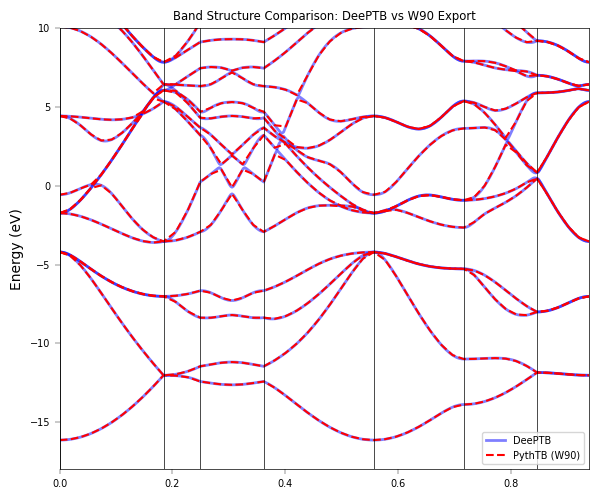

In [16]:

# Load using PythTB w90 module
w90_obj = w90(export_dir, prefix) 
tb_model = w90_obj.model()

print("Loaded W90 model into PythTB.")

# Use PythTB to calculate bands on the SAME k-path
# Reconstructing k-path from definition for PythTB (Linear logic)

k_nodes_pythtb = [
    [0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5],
    [0.625, 0.25, 0.625],
    [0.375, 0.375, 0.75],
    [0.0, 0.0, 0.0],
    [0.5, 0.5, 0.5],
    [0.5, 0.25, 0.75],
    [0.5, 0.0, 0.5]
]

# Note: DeePTB k-path generation handles segment point counts.
# We approximate to ensure smooth plotting.
(k_vec, k_dist, k_node) = tb_model.k_path(k_nodes_pythtb, 50) 

# Solve PythTB
evals_pythtb = tb_model.solve_all(k_vec)

# Plot Comparison
fig, ax = plt.subplots(figsize=(6, 5))
x_deep = band_data['xlist']

# Plot DeePTB (Blue lines)
nk, nb = eigens_np.shape
for i in range(nb):
    ax.plot(x_deep, eigens_np[:, i] - kpath_kwargs["E_fermi"], 'b-', lw=2, alpha=0.5, label='DeePTB' if i==0 else "")

# Plot PythTB (Red dashed)
# PythTB returns (nbands, nk_pythtb)
for i in range(evals_pythtb.shape[0]):
    ax.plot(k_dist, evals_pythtb[i,:] - kpath_kwargs["E_fermi"], 'r--', lw=1.5, label='PythTB (W90)' if i==0 else "")

for n in k_node:
    ax.axvline(n, color='k', lw=0.5)
ax.set_xlim(x_deep.min(),x_deep.max())
ax.set_ylim(kpath_kwargs["emin"], kpath_kwargs["emax"])
ax.set_ylabel("Energy (eV)",fontsize=10)
ax.set_title("Band Structure Comparison: DeePTB vs W90 Export")
ax.legend()
plt.tight_layout()
plt.show()